In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
import torchtext.experimental
import torchtext.experimental.vectors
from torchtext.experimental.datasets.raw.text_classification import RawTextIterableDataset
from torchtext.experimental.datasets.text_classification import TextClassificationDataset
from torchtext.experimental.functional import sequential_transforms, vocab_func, totensor

import matplotlib.pyplot as plt

import collections
import copy
import random
import time

In [2]:
seed = 1234

torch.manual_seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
raw_train_data, raw_test_data = torchtext.experimental.datasets.raw.IMDB()

In [4]:
raw_train_data = list(raw_train_data)
raw_test_data = list(raw_test_data)

In [5]:
def get_train_valid_split(raw_train_data, split_ratio = 0.7):
        
    random.shuffle(raw_train_data)
        
    n_train_examples = int(len(raw_train_data) * split_ratio)
        
    train_data = raw_train_data[:n_train_examples]
    valid_data = raw_train_data[n_train_examples:]
    
    return train_data, valid_data

In [6]:
raw_train_data, raw_valid_data = get_train_valid_split(raw_train_data)

In [7]:
class Tokenizer:
    def __init__(self, tokenize_fn = 'basic_english', lower = True, max_length = None, sos_token = None):
        
        self.tokenize_fn = torchtext.data.utils.get_tokenizer(tokenize_fn)
        self.lower = lower
        self.max_length = max_length
        self.sos_token = sos_token
        
    def tokenize(self, s):
        
        tokens = self.tokenize_fn(s)
        
        if self.lower:
            tokens = [token.lower() for token in tokens]
            
        if self.sos_token is not None:
            tokens = [self.sos_token] + tokens

        if self.max_length is not None:
            tokens = tokens[:self.max_length]
            
        return tokens

In [8]:
max_length = 250
sos_token = '<sos>'

tokenizer = Tokenizer(max_length = max_length, sos_token = sos_token)

In [9]:
s = "hello world, how are you?"

tokenizer.tokenize(s)

['<sos>', 'hello', 'world', ',', 'how', 'are', 'you', '?']

In [10]:
def build_vocab_from_data(raw_data, tokenizer, **vocab_kwargs):
        
    token_freqs = collections.Counter()
    
    for label, text in raw_data:
        tokens = tokenizer.tokenize(text)
        token_freqs.update(tokens)
                
    vocab = torchtext.vocab.Vocab(token_freqs, **vocab_kwargs)
    
    return vocab

In [11]:
max_size = 25_000

vocab = build_vocab_from_data(raw_train_data, 
                              tokenizer, 
                              max_size = max_size)

In [12]:
print(f'Unique tokens in vocab: {len(vocab):,}')

Unique tokens in vocab: 25,002


In [13]:
def raw_data_to_dataset(raw_data, tokenizer, vocab):
        
    text_transform = sequential_transforms(tokenizer.tokenize,
                                           vocab_func(vocab),
                                           totensor(dtype=torch.long))
    
    label_transform = sequential_transforms(lambda x: 1 if x == 'pos' else 0, 
                                            totensor(dtype=torch.long))

    transforms = (label_transform, text_transform)

    dataset = TextClassificationDataset(raw_data,
                                        vocab,
                                        transforms)
    
    return dataset

In [14]:
train_data = raw_data_to_dataset(raw_train_data, tokenizer, vocab)
valid_data = raw_data_to_dataset(raw_valid_data, tokenizer, vocab)
test_data = raw_data_to_dataset(raw_test_data, tokenizer, vocab)

In [15]:
print(f'Number of training examples: {len(train_data):,}')
print(f'Number of validation examples: {len(valid_data):,}')
print(f'Number of testing examples: {len(test_data):,}')

Number of training examples: 17,500
Number of validation examples: 7,500
Number of testing examples: 25,000


In [16]:
class Collator:
    def __init__(self, pad_idx, batch_first):
        
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        
    def collate(self, batch):
        
        labels, text = zip(*batch)
        
        labels = torch.LongTensor(labels)

        text = nn.utils.rnn.pad_sequence(text, 
                                         padding_value = self.pad_idx,
                                         batch_first = self.batch_first)
        
        return labels, text

In [17]:
pad_token = '<pad>'
pad_idx = vocab[pad_token]
batch_first = False

collator = Collator(pad_idx, batch_first)

In [18]:
batch_size = 256

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             batch_size, 
                                             shuffle = True, 
                                             collate_fn = collator.collate)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size, 
                                             shuffle = False, 
                                             collate_fn = collator.collate)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size, 
                                            shuffle = False, 
                                            collate_fn = collator.collate)

In [19]:
class DefaultTransformer(nn.Module):
    def __init__(self, input_dim, emb_dim, n_heads, hid_dim, n_layers, output_dim, dropout, max_length, pad_idx):
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, emb_dim, padding_idx = pad_idx)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.layer_norm = nn.LayerNorm(emb_dim)
        transformer_layer = nn.TransformerEncoderLayer(emb_dim, n_heads, hid_dim, activation = 'gelu')
        norm = nn.LayerNorm(emb_dim)
        self.transformer = nn.TransformerEncoder(transformer_layer, n_layers, norm)
        self.fc = nn.Linear(emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        # text = [seq len, batch size]

        seq_len, batch_size = text.shape
        
        pos = torch.arange(0, seq_len).unsqueeze(-1).repeat(1, batch_size).to(text.device)
        
        # pos = [seq len, batch size]
        
        embedded_pos = self.pos_embedding(pos)
        embedded_tok = self.tok_embedding(text)
        
        embedded = self.dropout(embedded_pos + embedded_tok)

        # embedded = [seq len, batch size, emb dim]

        emedded = self.layer_norm(embedded)
        
        # embedded = [seq len, batch size, emb dim]
        
        transformed = self.transformer(embedded)

        # transformed = [seq len, batch size, emb dim]

        sos_transformed = transformed[0]

        # sos_transformed = [batch size, emb dim]

        prediction = self.fc(self.dropout(sos_transformed))

        # prediction = [batch size, output dim]

        return prediction

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, n_layers, norm = None):
        super().__init__()
        
        self.encoder_layers = nn.ModuleList([copy.deepcopy(encoder_layer) 
                                             for _ in range(n_layers)])
        self.norm = norm
        
    def forward(self, embedded):
        
        # embedded = [seq len, batch size, emb dim]
        
        for layer in self.encoder_layers:
            embedded, attention = layer(embedded)
            
        # embedded = [seq len, batch size, emb dim]
            
        if self.norm is not None:
            embedded = self.norm(embedded)
        
        # embedded = [seq len, batch size, emb dim]
        
        return embedded, attention

In [21]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim, ff_layer, attention_layer, dropout):
        super().__init__()
        
        self.attention_layer = attention_layer
        self.ff_layer = ff_layer
        self.layer_norm_1 = nn.LayerNorm(emb_dim)
        self.layer_norm_2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, embedded):
        
        _embedded, attention = self.attention_layer(embedded, embedded, embedded)
        embedded = embedded + self.dropout(_embedded)
        embedded = self.layer_norm_1(embedded)
        _embedded = self.ff_layer(embedded)
        embedded = embedded + self.dropout(_embedded)
        embedded = self.layer_norm_2(embedded)
        
        return embedded, attention

In [22]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, emb_dim, n_heads, dropout):
        super().__init__()
        
        assert emb_dim % n_heads == 0
        
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        
        self.fc_q = nn.Linear(emb_dim, emb_dim)
        self.fc_k = nn.Linear(emb_dim, emb_dim)
        self.fc_v = nn.Linear(emb_dim, emb_dim)
        self.fc_o = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = self.head_dim ** -0.5
        
    def forward(self, query, key, value):
        
        # query/key/value = [seq len, batch size, emb dim]
        
        seq_len, batch_size, emb_dim = query.shape
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q/K/V = [seq len, batch size, emb dim]
        
        Q = Q.view(seq_len, batch_size, self.n_heads, self.head_dim)
        K = K.view(seq_len, batch_size, self.n_heads, self.head_dim)
        V = V.view(seq_len, batch_size, self.n_heads, self.head_dim)
        
        # Q/K/V = [seq len, batch size, n heads, head dim]
        
        Q = Q.permute(1, 2, 0, 3)
        K = K.permute(1, 2, 0, 3)
        V = V.permute(1, 2, 0, 3)
        
        # Q/K/V = [batch size, n heads, seq len, head dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scale
        
        # energy = [batch size, n heads, seq len, seq len]
        
        attention = torch.softmax(energy, dim = -1)
        
        # attention = [batch size, n heads, seq len, seq len]
        
        x = torch.matmul(self.dropout(attention), V)
        
        # x = [batch size, n heads, seq len, head dim]
        
        x = x.permute(2, 0, 1, 3).contiguous()
        
        # x = [seq len, batch size, n heads, head dim]
        
        x = x.view(seq_len, batch_size, emb_dim)
        
        # x = [seq len, batch size, emb dim]
        
        x = self.fc_o(x)
        
        # x = [seq len, batch size, emb dim]
        
        return x, attention

In [23]:
class FeedForwardLayer(nn.Module):
    def __init__(self, emb_dim, hid_dim, activation, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(emb_dim, hid_dim)
        self.fc_2 = nn.Linear(hid_dim, emb_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, embedded):
        
        # embedded = [seq len, batch size, emb dim]
        
        embedded = self.dropout(self.activation(self.fc_1(embedded)))
        
        # embedded = [seq len, batch size, hid dim]
        
        embedded = self.fc_2(embedded)
        
        # embedded = [seq len, batch size, emb dim]
        
        return embedded

In [24]:
class Transformer(nn.Module):
    def __init__(self, input_dim, emb_dim, encoder, output_dim, dropout, max_length, pad_idx):
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, emb_dim, padding_idx = pad_idx)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.encoder = encoder
        self.fc = nn.Linear(emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        # text = [seq len, batch size]

        seq_len, batch_size = text.shape
        
        pos = torch.arange(0, seq_len).unsqueeze(-1).repeat(1, batch_size).to(text.device)
        
        # pos = [seq len, batch size]
        
        embedded_pos = self.pos_embedding(pos)
        embedded_tok = self.tok_embedding(text)
        
        embedded = self.dropout(embedded_pos + embedded_tok)

        # embedded = [seq len, batch size, emb dim]

        emedded = self.layer_norm(embedded)
        
        # embedded = [seq len, batch size, emb dim]
        
        encoded, attention = self.encoder(embedded)

        # encoded = [seq len, batch size, emb dim]

        sos_encoded = encoded[0]

        # sos_encoded = [batch size, emb dim]

        prediction = self.fc(self.dropout(sos_encoded))

        # prediction = [batch size, output dim]

        return prediction, attention

In [25]:
input_dim = len(vocab)
emb_dim = 100
n_heads = 10
hid_dim = 1024
n_layers = 3
output_dim = 2
dropout = 0.1
pad_idx = pad_idx
ff_layer_activation = F.gelu
encoder_norm = nn.LayerNorm(emb_dim)

ff_layer = FeedForwardLayer(emb_dim, hid_dim, ff_layer_activation, dropout)
attention_layer = MultiHeadAttentionLayer(emb_dim, n_heads, dropout)
transformer_layer = TransformerEncoderLayer(emb_dim, ff_layer, attention_layer, dropout)
transformer_encoder = TransformerEncoder(transformer_layer, n_layers, encoder_norm)
model = Transformer(input_dim, emb_dim, transformer_encoder, output_dim, dropout, max_length, pad_idx)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,265,974 trainable parameters


In [28]:
for n, p in model.named_parameters():
    print(f'name: {n}, shape: {p.shape}')

name: tok_embedding.weight, shape: torch.Size([25002, 100])
name: pos_embedding.weight, shape: torch.Size([250, 100])
name: layer_norm.weight, shape: torch.Size([100])
name: layer_norm.bias, shape: torch.Size([100])
name: encoder.encoder_layers.0.attention_layer.fc_q.weight, shape: torch.Size([100, 100])
name: encoder.encoder_layers.0.attention_layer.fc_q.bias, shape: torch.Size([100])
name: encoder.encoder_layers.0.attention_layer.fc_k.weight, shape: torch.Size([100, 100])
name: encoder.encoder_layers.0.attention_layer.fc_k.bias, shape: torch.Size([100])
name: encoder.encoder_layers.0.attention_layer.fc_v.weight, shape: torch.Size([100, 100])
name: encoder.encoder_layers.0.attention_layer.fc_v.bias, shape: torch.Size([100])
name: encoder.encoder_layers.0.attention_layer.fc_o.weight, shape: torch.Size([100, 100])
name: encoder.encoder_layers.0.attention_layer.fc_o.bias, shape: torch.Size([100])
name: encoder.encoder_layers.0.ff_layer.fc_1.weight, shape: torch.Size([1024, 100])
name: en

In [29]:
def initialize_parameters(m):
    if isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, std = 0.02)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std = 0.02)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

In [30]:
model.apply(initialize_parameters)

Transformer(
  (tok_embedding): Embedding(25002, 100, padding_idx=1)
  (pos_embedding): Embedding(250, 100)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=100, out_features=100, bias=True)
          (fc_k): Linear(in_features=100, out_features=100, bias=True)
          (fc_v): Linear(in_features=100, out_features=100, bias=True)
          (fc_o): Linear(in_features=100, out_features=100, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff_layer): FeedForwardLayer(
          (fc_1): Linear(in_features=100, out_features=1024, bias=True)
          (fc_2): Linear(in_features=1024, out_features=100, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
 

In [31]:
glove = torchtext.experimental.vectors.GloVe(name = '6B',
                                             dim = emb_dim)

In [32]:
def get_pretrained_embedding(initial_embedding, pretrained_vectors, vocab, unk_token):
    
    pretrained_embedding = torch.FloatTensor(initial_embedding.weight.clone()).detach()    
    pretrained_vocab = pretrained_vectors.vectors.get_stoi()
    
    unk_tokens = []
    
    for idx, token in enumerate(vocab.itos):
        if token in pretrained_vocab:
            pretrained_vector = pretrained_vectors[token]
            pretrained_embedding[idx] = pretrained_vector
        else:
            unk_tokens.append(token)
        
    return pretrained_embedding, unk_tokens

In [33]:
unk_token = '<unk>'

pretrained_embedding, unk_tokens = get_pretrained_embedding(model.tok_embedding, glove, vocab, unk_token)

In [34]:
model.tok_embedding.weight.data.copy_(pretrained_embedding)

tensor([[-0.0017, -0.0139, -0.0213,  ...,  0.0069,  0.0128, -0.0211],
        [ 0.0157, -0.0071, -0.0066,  ..., -0.0251,  0.0035,  0.0269],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0288, -0.0316,  0.4083,  ...,  0.6288, -0.5348, -0.8080],
        [-0.0152,  0.0155, -0.0168,  ..., -0.0409,  0.0031,  0.0127],
        [-0.2612,  0.6821, -0.2295,  ..., -0.5306,  0.0863,  0.4852]])

In [35]:
model.tok_embedding.weight.data[pad_idx] = torch.zeros(emb_dim)

In [36]:
optimizer = optim.Adam(model.parameters())

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
model = model.to(device)
criterion = criterion.to(device)

In [40]:
def calculate_accuracy(predictions, labels):
    top_predictions = predictions.argmax(1, keepdim = True)
    correct = top_predictions.eq(labels.view_as(top_predictions)).sum()
    accuracy = correct.float() / labels.shape[0]
    return accuracy

In [41]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for labels, text in iterator:

        labels = labels.to(device)
        text = text.to(device)

        optimizer.zero_grad()
        
        predictions, attention = model(text)
        
        loss = criterion(predictions, labels)
        
        acc = calculate_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [42]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for labels, text in iterator:

            labels = labels.to(device)
            text = text.to(device)
            
            predictions, attention = model(text)
            
            loss = criterion(predictions, labels)
            
            acc = calculate_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
n_epochs = 10

best_valid_loss = float('inf')

for epoch in range(n_epochs):

    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.604 | Train Acc: 64.21%
	 Val. Loss: 0.457 |  Val. Acc: 78.76%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.364 | Train Acc: 84.16%
	 Val. Loss: 0.355 |  Val. Acc: 84.73%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.270 | Train Acc: 89.23%
	 Val. Loss: 0.384 |  Val. Acc: 84.55%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.206 | Train Acc: 92.15%
	 Val. Loss: 0.355 |  Val. Acc: 86.63%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.150 | Train Acc: 94.58%
	 Val. Loss: 0.435 |  Val. Acc: 86.43%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.101 | Train Acc: 96.54%
	 Val. Loss: 0.455 |  Val. Acc: 86.67%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.084 | Train Acc: 97.17%
	 Val. Loss: 0.505 |  Val. Acc: 84.09%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.066 | Train Acc: 97.82%
	 Val. Loss: 0.508 |  Val. Acc: 86.05%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.041 | Train Acc: 98.78%
	 Val. Loss: 0.605 |  Val. Acc: 86.25%
Epoch: 10 | Epoch T

In [45]:
model.load_state_dict(torch.load('transformer-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.371 | Test Acc: 85.62%


In [46]:
def predict_sentiment(tokenizer, vocab, model, device, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    indexes = [vocab.stoi[token] for token in tokens]
    tensor = torch.LongTensor(indexes).unsqueeze(-1).to(device)
    prediction, attention = model(tensor)
    probabilities = nn.functional.softmax(prediction, dim = -1)
    pos_probability = probabilities.squeeze()[-1].item()
    return pos_probability, attention

In [47]:
def display_attention(tokens, attention):
    
    fig = plt.figure(figsize=(10,20))
    
    attention = attention.cpu().detach().squeeze(0).mean(0)
    
    ax = fig.add_subplot(1,1,1)
    
    ax.matshow(attention, cmap='bone')
    
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens)

In [48]:
sentence = 'the absolute worst movie of all time.'

sentiment, attention = predict_sentiment(tokenizer, vocab, model, device, sentence)
print(sentiment)

0.0068605015985667706


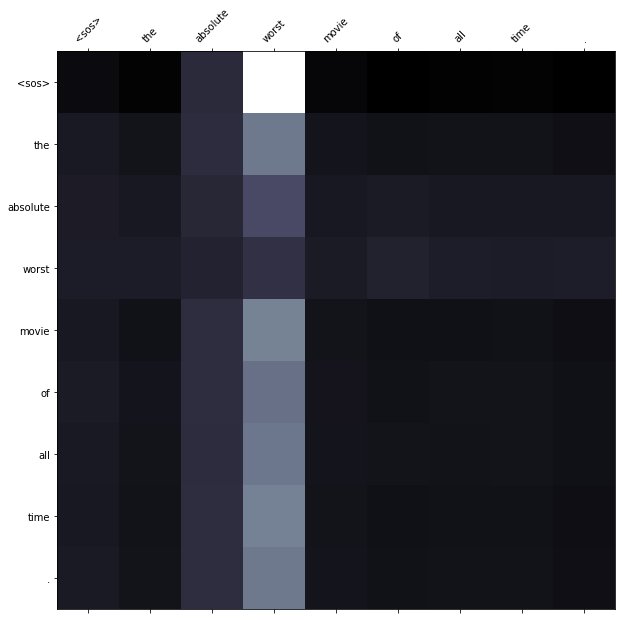

In [49]:
display_attention(tokenizer.tokenize(sentence), attention)

In [50]:
sentence = 'one of the greatest films i have ever seen in my life.'

sentiment, attention = predict_sentiment(tokenizer, vocab, model, device, sentence)
print(sentiment)

0.991644561290741


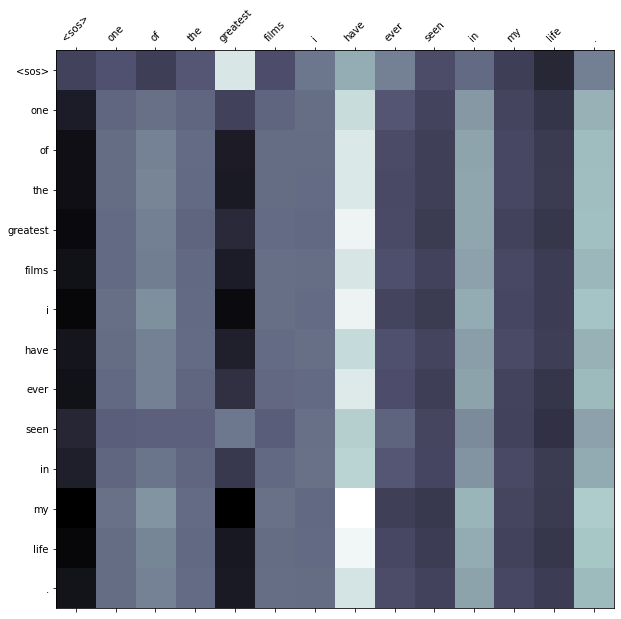

In [51]:
display_attention(tokenizer.tokenize(sentence), attention)

In [52]:
sentence = "i thought it was going to be one of the greatest films i have ever seen in my life, \
but it was actually the absolute worst movie of all time."

sentiment, attention = predict_sentiment(tokenizer, vocab, model, device, sentence)
print(sentiment)

0.051942430436611176


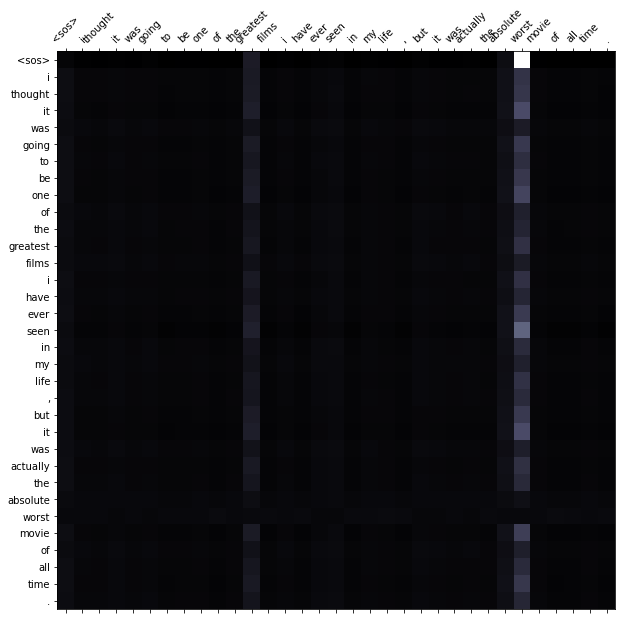

In [53]:
display_attention(tokenizer.tokenize(sentence), attention)

In [54]:
sentence = "i thought it was going to be the absolute worst movie of all time, \
but it was actually one of the greatest films i have ever seen in my life."

sentiment, attention = predict_sentiment(tokenizer, vocab, model, device, sentence)
print(sentiment)

0.06497201323509216


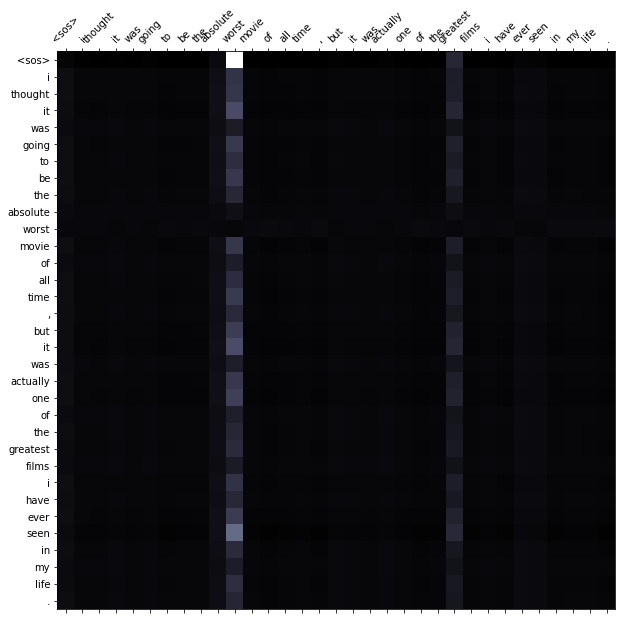

In [55]:
display_attention(tokenizer.tokenize(sentence), attention)

In [56]:
def count_pos_neg_token(token, tokenizer, data):
    n_examples = {'pos': 0, 'neg': 0}
    n_count = {'pos': 0, 'neg': 0}
    for label, text in data.data:
        tokens = tokenizer.tokenize(text)
        count = tokens.count(token)
        if count > 0:
            n_examples[label] += 1
            n_count[label] += count
    return n_examples['pos'], n_count['pos'], n_examples['neg'], n_count['neg']

In [57]:
token = 'worst'

n_pos, count_pos, n_neg, count_neg = count_pos_neg_token(token, tokenizer, train_data)

print(f'"{token}" appears in {n_pos} positive examples, {count_pos} times in total.')
print(f'"{token}" appears in {n_neg} negative examples, {count_neg} times in total.')

"worst" appears in 106 positive examples, 111 times in total.
"worst" appears in 1246 negative examples, 1457 times in total.


In [58]:
token = 'greatest'

n_pos, count_pos, n_neg, count_neg = count_pos_neg_token(token, tokenizer, train_data)

print(f'"{token}" appears in {n_pos} positive examples, {count_pos} times in total.')
print(f'"{token}" appears in {n_neg} negative examples, {count_neg} times in total.')

"greatest" appears in 242 positive examples, 264 times in total.
"greatest" appears in 86 negative examples, 91 times in total.
